In [20]:
## now fit a gaussian mixture to these datasets, using pystan

import numpy as np
import stan
import pandas as pd
import nest_asyncio
nest_asyncio.apply() # necessary if running in a jupyter notebook

# define the stan model
# we have 100 sites, each with 720 observations

model_code = """
data {
  int<lower=0> N;          // number of data points
  array[N] real y;               // observed data
}

parameters {
  real mu1;                // mean of the first Gaussian
  real mu2;                // mean of the second Gaussian
  real<lower=0> sigma1;    // standard deviation of the first Gaussian
  real<lower=0> sigma2;    // standard deviation of the second Gaussian
  real<lower=0,upper=1> theta;  // mixing proportion
}

model {
  vector[2] log_lik;       // log likelihood for each component
  for (n in 1:N) {
    log_lik[1] = log(theta) + normal_lpdf(y[n] | mu1, sigma1);
    log_lik[2] = log1m(theta) + normal_lpdf(y[n] | mu2, sigma2);
    target += log_sum_exp(log_lik);
  }

  // Priors (these can be adjusted as needed)
  mu1 ~ normal(0, 10);
  mu2 ~ normal(0, 10);
  sigma1 ~ cauchy(0, 2);
  sigma2 ~ cauchy(0, 2);
  theta ~ beta(1, 1);
}
"""

# read in the generated data
pop_lambda = 1.05
p_call = 0.1

fname = f"./simulated_data/simulated_data_lambda_{pop_lambda:.2f}_p_call_{p_call:.2f}.csv"
data = pd.read_csv(fname)

# get just the first row
data = data.iloc[0]

# convert the data to a dictionary
data = {
    'y': data.values,
    'N': len(data)
}

# compile the model
posterior = stan.build(model_code, data=data, random_seed=1)

fit = posterior.sample(num_chains=4, num_samples=1000, num_warmup=500)


Building...


Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000669 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.69 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_lgdokofx/model_h4j2xdab.stan', line 18, column 4 to column 62)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 0.000496 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.96 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis propo

In [21]:
df = fit.to_frame()

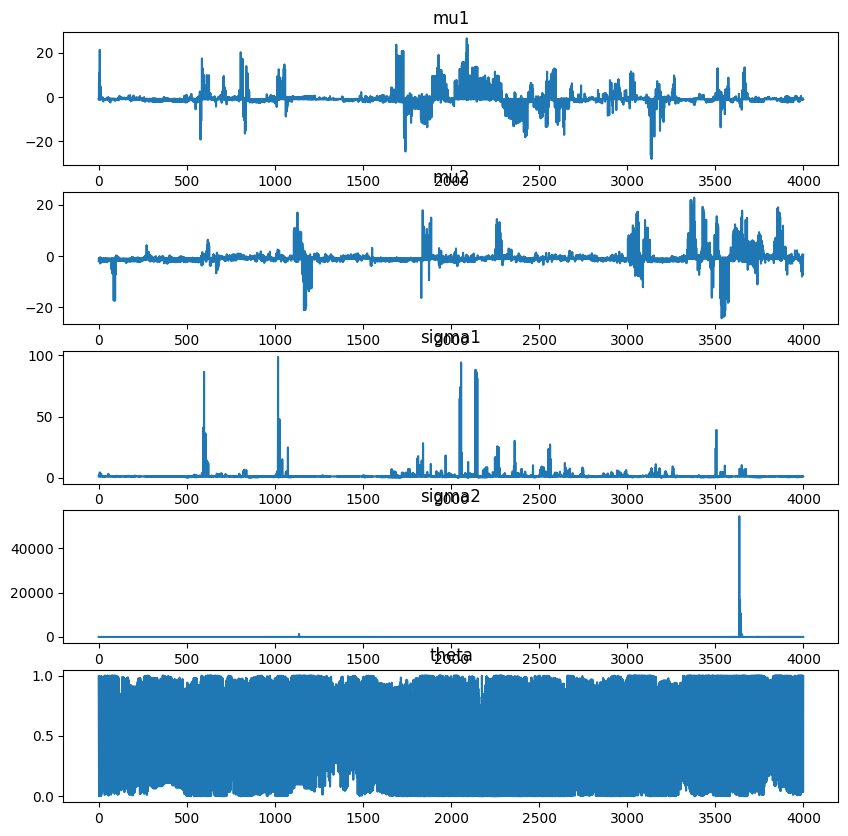

In [10]:
# plot the values for mu1, mu2, sigma1, sigma2, and theta
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
axs = axs.ravel()
for i, param in enumerate(['mu1', 'mu2', 'sigma1', 'sigma2', 'theta']):
    axs[i].plot(df[param])
    axs[i].set_title(param)